In [ ]:
!pip install perceiver-pytorch


In [ ]:
import torch
import cv2
import numpy as np
import torch.optim as optim
import torchvision

from google.colab.patches import cv2_imshow
from perceiver_pytorch import Perceiver
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


##################
batch_size = 128
size = 64
objects = 1
##################

In [ ]:
model = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 4,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 5.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 2,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    cross_dim = 32,             # cross attention dimension
    latent_dim = 32,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 32,
    latent_dim_head = 32,
    num_classes = 4*objects,          # output number of classes
    attn_dropout = 0.5,
    ff_dropout = 0.5,
    weight_tie_layers = True    # whether to weight tie layers (optional, as indicated in the diagram)
)

In [ ]:
# training the model on very easy object detection problem
class CustomDataset(Dataset):
    def __init__(self):   
      pass
      
    def __len__(self):
        return 320000

    def __getitem__(self, idx):
        image = np.zeros((size,size,3), np.uint8)
        labels = []

        for i in range(objects):
          if (np.random.rand() > 0.02):
            point_x = int(np.random.rand() * size)
            point_y = int(np.random.rand() * size)
            size_x = int(np.random.rand() * size)
            size_y = int(np.random.rand() * size)       
            r, g, b = int(np.random.rand()*255), int(np.random.rand()*255), int(np.random.rand() * 255)  
            try:
              cv2.rectangle(image, (int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)), (r, g, b), -1)            
              labels.append((point_x/size, point_y/size, size_x/size, size_y/size))
            except Exception as e:
              print(e)
              labels.append((0,0,0,0))
          else:            
            labels.append((0,0,0,0))            
                  
        labels = torch.as_tensor(labels, dtype=torch.float32)
        image = torch.as_tensor(image, dtype=torch.float32)

        return (image, labels)



criterion = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

model.cuda()
model.train()


for epoch in range(20):  # loop over the dataset multiple times

  running_loss = 0.0

  for i, batch in enumerate(dataloader):

    img, labels = batch    
        
    img = torch.as_tensor(img, dtype=torch.float32).cuda()

    labels = torch.as_tensor(labels, dtype=torch.float32).cuda()    
    labels = labels.flatten()
    labels = torch.reshape(labels, (batch_size, 4*objects))
     
    optimizer.zero_grad()
    out = model(img)
        
   
    loss = criterion(out, labels)             
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 20 == 19:    # print every 2000 mini-batches
        print('[%d, %6d] loss: %.6f' %
              (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0
    

input image:


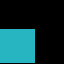

input box location (x, y), (w, h):
(-18, 29) (34, 62)
--------------------------------------------------
predicted output:


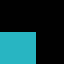

predicted box location (x, y), (w, h):
(-11, 32) (35, 70)
--------------------------------------------------
inference time was: 11.744499206542969  ms


In [ ]:
# testing the trained model

model = model.eval()
import time



np.random.seed(np.random.randint(0, 99999))

image = np.zeros((size,size, 3), np.uint8)
labels = []
model = model.cuda()

point_x = int(np.random.rand() * size)
point_y = int(np.random.rand() * size)
size_x = int(np.random.rand() * size)
size_y = int(np.random.rand() * size)       
r, g, b = int(np.random.rand()*255), int(np.random.rand()*255), int(np.random.rand() * 255)  

cv2.rectangle(image, (int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)), (r, g, b), -1)            

print("input image:")
cv2_imshow(image)
print("input box location (x, y), (w, h):")
print((int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)))

image_tensor = torch.as_tensor(image, dtype=torch.float32)

image_tensor = torch.unsqueeze(image_tensor, 0).cuda()    

image2 = np.ones((size,size, 3), np.uint8)

t1 = time.time()
for i in range(1):
  out = model(image_tensor)
  out = out[0].detach().cpu().numpy()
  
out_point_x = int(out[0] * size)
out_point_y = int(out[1] * size)
out_size_x = int(out[2] * size)
out_size_y = int(out[3] * size)

cv2.rectangle(image2, (int(out_point_x - out_size_x/2), int(out_point_y - out_size_y/2)), (int(out_point_x + out_size_x/2), int(out_point_y + out_size_y/2)), (r, g, b), -1)            

print("-"*50)
print("predicted output:")
cv2_imshow(image2)
print("predicted box location (x, y), (w, h):")
print((int(out_point_x - out_size_x/2), int(out_point_y - out_size_y/2)), (int(out_point_x + out_size_x/2), int(out_point_y + out_size_y/2)))
print("-"*50)
print(f'inference time was: {(time.time() - t1) * 1000}  ms')
